## Analyzing trajectory set 1

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
import shapely as shp
import hvplot.pandas 
import matplotlib.pyplot as plt
from utils import *
from geopandas import GeoDataFrame, read_file
from shapely.geometry import Point, LineString, Polygon
from datetime import datetime, timedelta
from holoviews import opts, dim
from os.path import exists
from urllib.request import urlretrieve
import seaborn as sns
from hausdorff import hausdorff_distance
from scipy.spatial.distance import directed_hausdorff
from sklearn.cluster import DBSCAN
import hdbscan
import warnings
from dtw import *
from haversine import haversine
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import davies_bouldin_score 
from sdtw import SoftDTW
warnings.filterwarnings('ignore')

plot_defaults = {'linewidth':5, 'capstyle':'round', 'figsize':(9,3), 'legend':True}
opts.defaults(opts.Overlay(active_tools=['wheel_zoom'], frame_width=600, frame_height=400))
hvplot_defaults = {'tiles':None, 'cmap':'Viridis', 'colorbar':True}

from sklearn import metrics
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
from cartopy.io.img_tiles import OSM
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



## We can now start to cluster the trajectories between some main traffic spots

The first trajectory segment is chosen between Colombo (80.5 E) and the entrance of Suez Canal (43.5 E)

In [2]:
df = pd.read_csv('intersection_2021_72.csv')

In [3]:
# define the boundary
df_traj = df[df['Lng'] > 43.5]
df_traj = df_traj[df_traj['Lng'] < 80.1]
# df_sg2sc = df_sg2sc[df_sg2sc['Lat'] < 17]
df_traj = df_traj[df_traj['Lat'] > 1.135]

area_of_cl = Polygon([(77, 5.6), (77,  8), (80.6, 8), (80.6, 5.6)]) # Colombo
area_of_sc = Polygon([(43, 13), (43,  11.5), (46, 11.5), (46, 13)]) # Suez canal

gdf = gpd.GeoDataFrame(df_traj, geometry=gpd.points_from_xy(df_traj.Lng, df_traj.Lat))

traj_collection = mpd.TrajectoryCollection(gdf, 'LLI NO', t='t', crs="EPSG:4326 WGS84")
traj = find_intersection(traj_collection, area_of_cl, area_of_sc)

print(f"Found {len(traj)} trajectories between Colombo and Suez Canal")
df_traje_all = traj.to_traj_gdf()

Found 444 trajectories
Found 444 trajectories between Colombo and Suez Canal


<Axes: xlabel='company'>

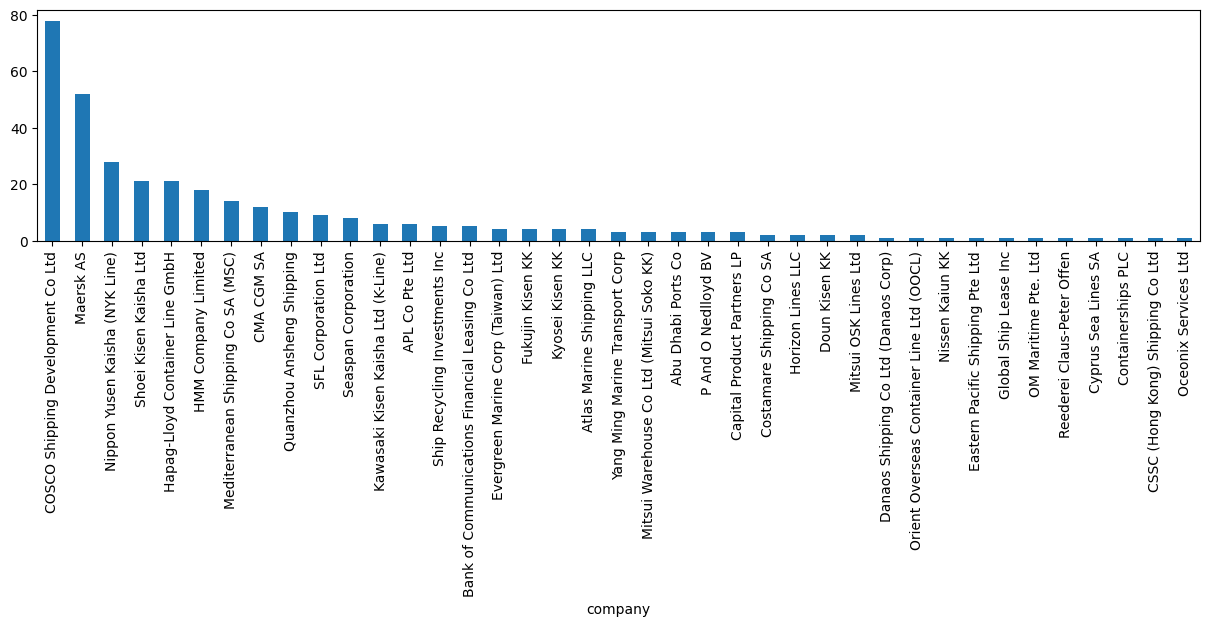

In [4]:
df_traje_all['IMO'] = np.nan

df1=pd.read_csv('container.csv')
df1['LLINO'] = df1['LLINO'].astype(str)
LLIstring = df1['LLINO']

IMOstring = df1['IMO']

for i in range(0, LLIstring.shape[0]):
    id = df_traje_all[df_traje_all['LLI NO'].str.contains(LLIstring[i], na=False)].index
    if (id.empty):
        continue
    else:
        for j in range(0, id.shape[0]):
            # df_traj[id[j], 'IMO'] = IMOstring[j]
            df_traje_all.loc[id[j], 'IMO'] = IMOstring[i]

df_traje_all['flag'] = np.nan
df_traje_all['company'] = np.nan
df_traje_all['IMO'] = df_traje_all['IMO'].astype(str)

df_IMO_company = pd.read_csv('info.csv')

IMOString = df_IMO_company['IMO'].astype(str)

for i in range(0, IMOString.shape[0]):
    id = df_traje_all[df_traje_all['IMO'].str.contains(IMOString[i], na=False)].index
    if (id.empty):
        continue
    else:
        for j in range(0, id.shape[0]):
            # df_traj[id[j], 'IMO'] = IMOstring[j]
            df_traje_all.loc[id[j], 'flag'] = df_IMO_company.loc[i, 'Flag']
            df_traje_all.loc[id[j], 'company'] = df_IMO_company.loc[i, 'Company']


df_traje_all = df_traje_all.drop(df_traje_all[df_traje_all['company'] == 'no record'].index)
df_traje_all['company'].value_counts().plot(kind='bar', figsize=(15,3))

In [12]:
df_traje_all['company'].value_counts()

company
COSCO Shipping Development Co Ltd                  78
Maersk AS                                          52
Nippon Yusen Kaisha (NYK Line)                     28
Shoei Kisen Kaisha Ltd                             21
Hapag-Lloyd Container Line GmbH                    21
HMM Company Limited                                18
Mediterranean Shipping Co SA (MSC)                 14
CMA CGM SA                                         12
Quanzhou Ansheng Shipping                          10
SFL Corporation Ltd                                 9
Seaspan Corporation                                 8
Kawasaki Kisen Kaisha Ltd (K-Line)                  6
APL Co Pte Ltd                                      6
Ship Recycling Investments Inc                      5
Bank of Communications Financial Leasing Co Ltd     5
Evergreen Marine Corp (Taiwan) Ltd                  4
Fukujin Kisen KK                                    4
Kyosei Kisen KK                                     4
Atlas Marine Shippin

In [4]:
# from india to suez canal
traj_list_cl2sc = [traje for traje in traj if traje.get_start_location().intersects(area_of_cl)]
traj_list_sc2cl = [traje for traje in traj if traje.get_start_location().intersects(area_of_sc)]
traj_collection_cl2sc = mpd.TrajectoryCollection(traj_list_cl2sc)
traj_collection_sc2cl = mpd.TrajectoryCollection(traj_list_sc2cl)
print(f"Found {len(traj_list_cl2sc)} trajectories from Colombo to Suez canal")
print(f"Found {len(traj_list_sc2cl)} trajectories from suez canal to Colombo")

df_traje = traj_collection_cl2sc.to_traj_gdf()
df_traje_reverse = traj_collection_sc2cl.to_traj_gdf()

Found 230 trajectories from Colombo to Suez canal
Found 210 trajectories from suez canal to Colombo


In [20]:
df_traje['IMO'] = np.nan

df1=pd.read_csv('container.csv')
df1['LLINO'] = df1['LLINO'].astype(str)
LLIstring = df1['LLINO']

IMOstring = df1['IMO']

for i in range(0, LLIstring.shape[0]):
    id = df_traje[df_traje['LLI NO'].str.contains(LLIstring[i], na=False)].index
    if (id.empty):
        continue
    else:
        for j in range(0, id.shape[0]):
            # df_traj[id[j], 'IMO'] = IMOstring[j]
            df_traje.loc[id[j], 'IMO'] = IMOstring[i]

df_traje['flag'] = np.nan
df_traje['company'] = np.nan
df_traje['IMO'] = df_traje['IMO'].astype(str)

df_IMO_company = pd.read_csv('info.csv')

IMOString = df_IMO_company['IMO'].astype(str)

for i in range(0, IMOString.shape[0]):
    id = df_traje[df_traje['IMO'].str.contains(IMOString[i], na=False)].index
    if (id.empty):
        continue
    else:
        for j in range(0, id.shape[0]):
            # df_traj[id[j], 'IMO'] = IMOstring[j]
            df_traje.loc[id[j], 'flag'] = df_IMO_company.loc[i, 'Flag']
            df_traje.loc[id[j], 'company'] = df_IMO_company.loc[i, 'Company']

In [21]:
df_flag = df_traje
df_flag = df_flag.drop(df_flag[df_flag['company'] == 'no record'].index)

df_flag_1 = df_flag[df_flag['company'] == 'COSCO Shipping Development Co Ltd']
df_flag_2 = df_flag[df_flag['company'] == 'Maersk AS']

df_flag_3 = df_flag[df_flag['company'] == 'Nippon Yusen Kaisha (NYK Line)']
df_flag_4 = df_flag[df_flag['company'] == 'Hapag-Lloyd Container Line GmbH']
# traj_flag_1 = mpd.Trajectory(df_flag_1, 'LLI NO')
df_flag_1.hvplot(title='COSCO', geo=True, hover_cols=['weight'], line_width=1, color='b', tiles='EsriNatGeo', frame_height=800, frame_width=500) +\
df_flag_2.hvplot(title='Maersk AS', geo=True, hover_cols=['weight'], line_width=1, color='b', tiles='EsriNatGeo', frame_height=800, frame_width=500)

:Layout
   .Overlay.I  :Overlay
      .WMTS.I :WMTS   [Longitude,Latitude]
      .Path.I :Path   [Longitude,Latitude]
   .Overlay.II :Overlay
      .WMTS.I :WMTS   [Longitude,Latitude]
      .Path.I :Path   [Longitude,Latitude]

In [8]:
df_flag_3.hvplot(title='Nippon Yusen Kaisha (NYK Line)', geo=True, hover_cols=['weight'], line_width=1, color='b', tiles='EsriNatGeo', frame_height=800, frame_width=500) +\
df_flag_4.hvplot(title='Hapag-Lloyd Container Line GmbH', geo=True, hover_cols=['weight'], line_width=1, color='b', tiles='EsriNatGeo', frame_height=800, frame_width=500)

:Layout
   .Overlay.I  :Overlay
      .WMTS.I :WMTS   [Longitude,Latitude]
      .Path.I :Path   [Longitude,Latitude]
   .Overlay.II :Overlay
      .WMTS.I :WMTS   [Longitude,Latitude]
      .Path.I :Path   [Longitude,Latitude]

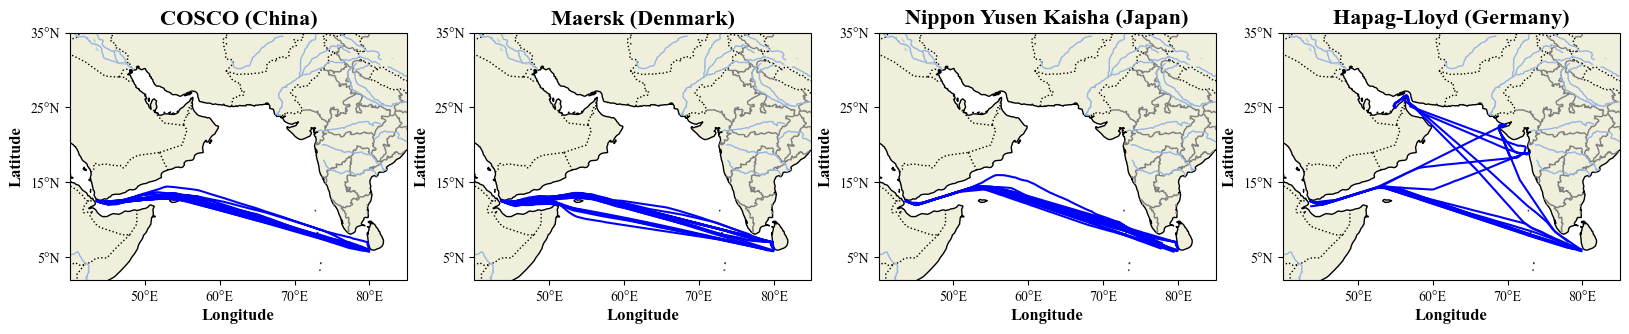

In [45]:


fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1, 4, 1, projection=ccrs.PlateCarree())
ax = df_flag_1.plot(ax = ax, color="blue")
ax.set_extent([40, 85, 2, 30], crs=ccrs.PlateCarree())
# ax.stock_img()
# states_provinces = cfeature.NaturalEarthFeature(
#         category='cultural',
#         name='admin_1_states_provinces_lines',
#         scale='50m',
#         facecolor='none')
SOURCE = 'Natural Earth'
LICENSE = 'public domain'
# ax.add_image(imagery)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)


fontlabel = {'family': 'times new roman',
        'color':  'black',
        'weight': 'bold',
        'size': 12,
        }
fonttitle = {'family': 'times new roman',
        'color':  'black',
        'weight': 'bold',
        'size': 16,
        }

ax.set_xticks([50, 60, 70, 80], crs=ccrs.PlateCarree())
ax.set_yticks([5, 15, 25, 35], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
x1_label = ax.get_xticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
y1_label = ax.get_yticklabels() 
[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]
plt.title('COSCO (China)', fontdict=fonttitle)
plt.xlabel('Longitude', fontdict=fontlabel)
plt.ylabel('Latitude', fontdict=fontlabel)


ax = fig.add_subplot(1, 4, 2, projection=ccrs.PlateCarree())
ax = df_flag_2.plot(ax = ax, color="blue")
ax.set_extent([40, 85, 2, 30], crs=ccrs.PlateCarree())
# ax.stock_img()
# states_provinces = cfeature.NaturalEarthFeature(
#         category='cultural',
#         name='admin_1_states_provinces_lines',
#         scale='50m',
#         facecolor='none')
SOURCE = 'Natural Earth'
LICENSE = 'public domain'
# ax.add_image(imagery)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

ax.set_xticks([50, 60, 70, 80], crs=ccrs.PlateCarree())
ax.set_yticks([5, 15, 25, 35], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
x1_label = ax.get_xticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
y1_label = ax.get_yticklabels() 
[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]


plt.title('Maersk (Denmark)', fontdict=fonttitle)
plt.xlabel('Longitude', fontdict=fontlabel)
plt.ylabel('Latitude', fontdict=fontlabel)


ax = fig.add_subplot(1, 4, 3, projection=ccrs.PlateCarree())
ax = df_flag_3.plot(ax = ax, color="blue")
ax.set_extent([40, 85, 2, 30], crs=ccrs.PlateCarree())
# ax.stock_img()
# states_provinces = cfeature.NaturalEarthFeature(
#         category='cultural',
#         name='admin_1_states_provinces_lines',
#         scale='50m',
#         facecolor='none')
SOURCE = 'Natural Earth'
LICENSE = 'public domain'
# ax.add_image(imagery)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

ax.set_xticks([50, 60, 70, 80], crs=ccrs.PlateCarree())
ax.set_yticks([5, 15, 25, 35], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
x1_label = ax.get_xticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
y1_label = ax.get_yticklabels() 
[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]


plt.title('Nippon Yusen Kaisha (Japan)', fontdict=fonttitle)
plt.xlabel('Longitude', fontdict=fontlabel)
plt.ylabel('Latitude', fontdict=fontlabel)


ax = fig.add_subplot(1, 4, 4, projection=ccrs.PlateCarree())
ax = df_flag_4.plot(ax = ax, color="blue")
ax.set_extent([40, 85, 2, 30], crs=ccrs.PlateCarree())
# ax.stock_img()
# states_provinces = cfeature.NaturalEarthFeature(
#         category='cultural',
#         name='admin_1_states_provinces_lines',
#         scale='50m',
#         facecolor='none')
SOURCE = 'Natural Earth'
LICENSE = 'public domain'
# ax.add_image(imagery)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

ax.set_xticks([50, 60, 70, 80], crs=ccrs.PlateCarree())
ax.set_yticks([5, 15, 25, 35], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
x1_label = ax.get_xticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
y1_label = ax.get_yticklabels() 
[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]


plt.title('Hapag-Lloyd (Germany)', fontdict=fonttitle)
plt.xlabel('Longitude', fontdict=fontlabel)
plt.ylabel('Latitude', fontdict=fontlabel)

# fig.savefig('company cl2sc.png', dpi=600)
plt.show()

In [9]:
df_traje_reverse['IMO'] = np.nan

df1=pd.read_csv('container.csv')
df1['LLINO'] = df1['LLINO'].astype(str)
LLIstring = df1['LLINO']

IMOstring = df1['IMO']

for i in range(0, LLIstring.shape[0]):
    id = df_traje_reverse[df_traje_reverse['LLI NO'].str.contains(LLIstring[i], na=False)].index
    if (id.empty):
        continue
    else:
        for j in range(0, id.shape[0]):
            # df_traj[id[j], 'IMO'] = IMOstring[j]
            df_traje_reverse.loc[id[j], 'IMO'] = IMOstring[i]

df_traje_reverse['flag'] = np.nan
df_traje_reverse['company'] = np.nan
df_traje_reverse['IMO'] = df_traje_reverse['IMO'].astype(str)

df_IMO_company = pd.read_csv('info.csv')

IMOString = df_IMO_company['IMO'].astype(str)

for i in range(0, IMOString.shape[0]):
    id = df_traje_reverse[df_traje_reverse['IMO'].str.contains(IMOString[i], na=False)].index
    if (id.empty):
        continue
    else:
        for j in range(0, id.shape[0]):
            # df_traj[id[j], 'IMO'] = IMOstring[j]
            df_traje_reverse.loc[id[j], 'flag'] = df_IMO_company.loc[i, 'Flag']
            df_traje_reverse.loc[id[j], 'company'] = df_IMO_company.loc[i, 'Company']

:Layout
   .Overlay.I  :Overlay
      .WMTS.I :WMTS   [Longitude,Latitude]
      .Path.I :Path   [Longitude,Latitude]
   .Overlay.II :Overlay
      .WMTS.I :WMTS   [Longitude,Latitude]
      .Path.I :Path   [Longitude,Latitude]

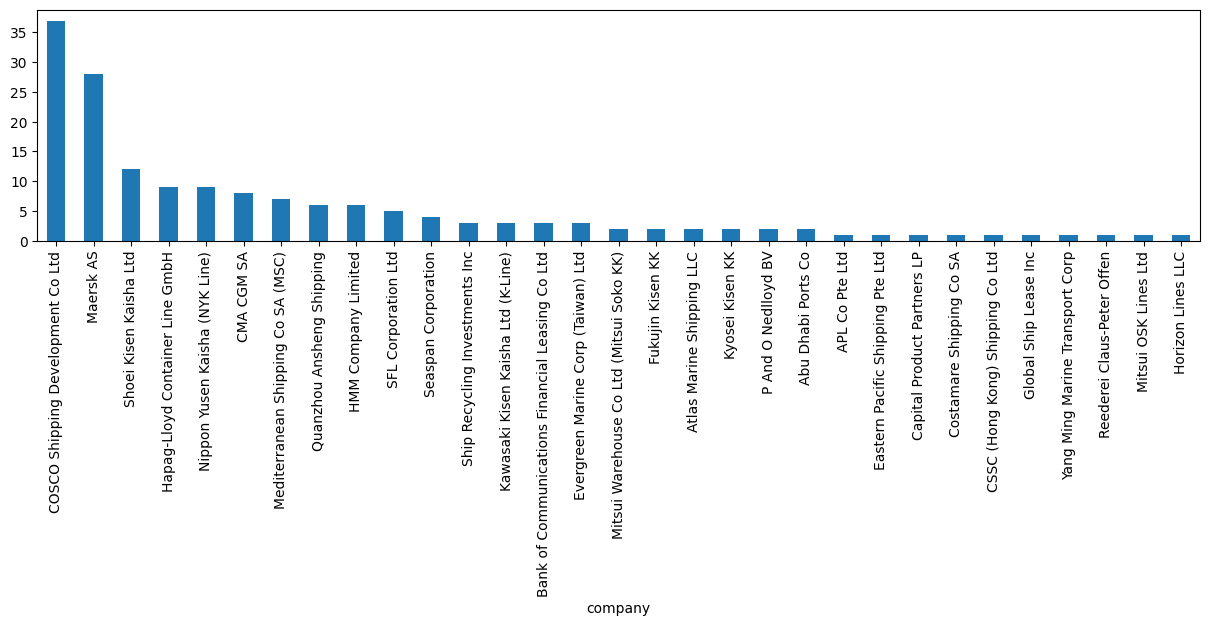

In [10]:
df_flag = df_traje_reverse
df_flag = df_flag.drop(df_flag[df_flag['company'] == 'no record'].index)
df_flag['company'].value_counts().plot(kind='bar', figsize=(15,3))
df_flag_1 = df_flag[df_flag['company'] == 'COSCO Shipping Development Co Ltd']
df_flag_2 = df_flag[df_flag['company'] == 'Maersk AS']

df_flag_3 = df_flag[df_flag['company'] == 'Nippon Yusen Kaisha (NYK Line)']
df_flag_4 = df_flag[df_flag['company'] == 'Hapag-Lloyd Container Line GmbH']
# traj_flag_1 = mpd.Trajectory(df_flag_1, 'LLI NO')
df_flag_1.hvplot(title='COSCO', geo=True, hover_cols=['weight'], line_width=1, color='r', tiles='EsriNatGeo', frame_height=800, frame_width=500) +\
df_flag_2.hvplot(title='Maersk AS', geo=True, hover_cols=['weight'], line_width=1, color='r', tiles='EsriNatGeo', frame_height=800, frame_width=500)

In [11]:
df_flag_3.hvplot(title='Nippon Yusen Kaisha (NYK Line)', geo=True, hover_cols=['weight'], line_width=1, color='r', tiles='EsriNatGeo', frame_height=800, frame_width=500) +\
df_flag_4.hvplot(title='Hapag-Lloyd Container Line GmbH', geo=True, hover_cols=['weight'], line_width=1, color='r', tiles='EsriNatGeo', frame_height=800, frame_width=500)

:Layout
   .Overlay.I  :Overlay
      .WMTS.I :WMTS   [Longitude,Latitude]
      .Path.I :Path   [Longitude,Latitude]
   .Overlay.II :Overlay
      .WMTS.I :WMTS   [Longitude,Latitude]
      .Path.I :Path   [Longitude,Latitude]

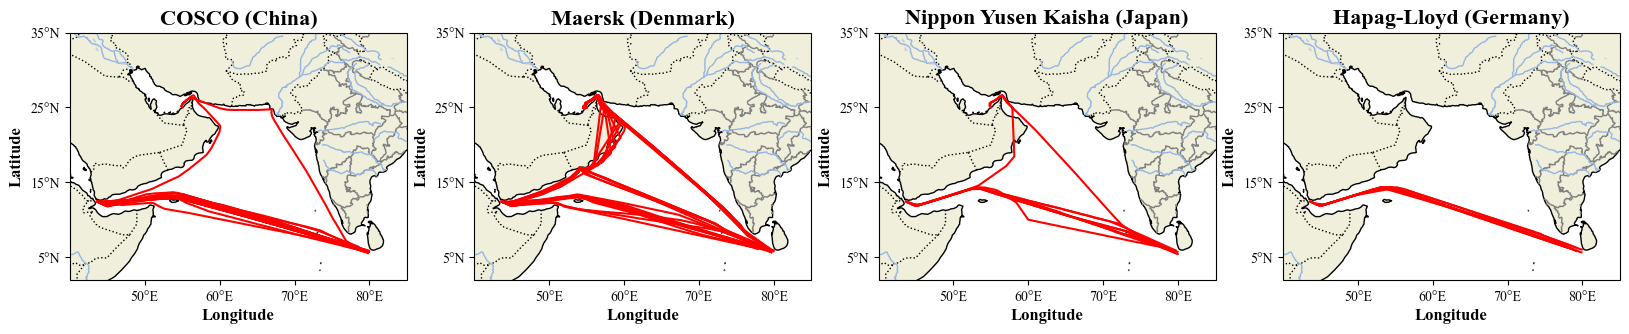

In [42]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1, 4, 1, projection=ccrs.PlateCarree())
ax = df_flag_1.plot(ax = ax, color="red")
ax.set_extent([40, 85, 2, 30], crs=ccrs.PlateCarree())
# ax.stock_img()
# states_provinces = cfeature.NaturalEarthFeature(
#         category='cultural',
#         name='admin_1_states_provinces_lines',
#         scale='50m',
#         facecolor='none')
SOURCE = 'Natural Earth'
LICENSE = 'public domain'
# ax.add_image(imagery)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)


fontlabel = {'family': 'times new roman',
        'color':  'black',
        'weight': 'bold',
        'size': 12,
        }
fonttitle = {'family': 'times new roman',
        'color':  'black',
        'weight': 'bold',
        'size': 16,
        }

ax.set_xticks([50, 60, 70, 80], crs=ccrs.PlateCarree())
ax.set_yticks([5, 15, 25, 35], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
x1_label = ax.get_xticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
y1_label = ax.get_yticklabels() 
[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]
plt.title('COSCO (China)', fontdict=fonttitle)
plt.xlabel('Longitude', fontdict=fontlabel)
plt.ylabel('Latitude', fontdict=fontlabel)


ax = fig.add_subplot(1, 4, 2, projection=ccrs.PlateCarree())
ax = df_flag_2.plot(ax = ax, color="red")
ax.set_extent([40, 85, 2, 30], crs=ccrs.PlateCarree())
# ax.stock_img()
# states_provinces = cfeature.NaturalEarthFeature(
#         category='cultural',
#         name='admin_1_states_provinces_lines',
#         scale='50m',
#         facecolor='none')
SOURCE = 'Natural Earth'
LICENSE = 'public domain'
# ax.add_image(imagery)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

ax.set_xticks([50, 60, 70, 80], crs=ccrs.PlateCarree())
ax.set_yticks([5, 15, 25, 35], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
x1_label = ax.get_xticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
y1_label = ax.get_yticklabels() 
[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]


plt.title('Maersk (Denmark)', fontdict=fonttitle)
plt.xlabel('Longitude', fontdict=fontlabel)
plt.ylabel('Latitude', fontdict=fontlabel)


ax = fig.add_subplot(1, 4, 3, projection=ccrs.PlateCarree())
ax = df_flag_3.plot(ax = ax, color="red")
ax.set_extent([40, 85, 2, 30], crs=ccrs.PlateCarree())
# ax.stock_img()
# states_provinces = cfeature.NaturalEarthFeature(
#         category='cultural',
#         name='admin_1_states_provinces_lines',
#         scale='50m',
#         facecolor='none')
SOURCE = 'Natural Earth'
LICENSE = 'public domain'
# ax.add_image(imagery)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

ax.set_xticks([50, 60, 70, 80], crs=ccrs.PlateCarree())
ax.set_yticks([5, 15, 25, 35], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
x1_label = ax.get_xticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
y1_label = ax.get_yticklabels() 
[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]


plt.title('Nippon Yusen Kaisha (Japan)', fontdict=fonttitle)
plt.xlabel('Longitude', fontdict=fontlabel)
plt.ylabel('Latitude', fontdict=fontlabel)


ax = fig.add_subplot(1, 4, 4, projection=ccrs.PlateCarree())
ax = df_flag_4.plot(ax = ax, color="red")
ax.set_extent([40, 85, 2, 30], crs=ccrs.PlateCarree())
# ax.stock_img()
# states_provinces = cfeature.NaturalEarthFeature(
#         category='cultural',
#         name='admin_1_states_provinces_lines',
#         scale='50m',
#         facecolor='none')
SOURCE = 'Natural Earth'
LICENSE = 'public domain'
# ax.add_image(imagery)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

ax.set_xticks([50, 60, 70, 80], crs=ccrs.PlateCarree())
ax.set_yticks([5, 15, 25, 35], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
x1_label = ax.get_xticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
y1_label = ax.get_yticklabels() 
[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]


plt.title('Hapag-Lloyd (Germany)', fontdict=fonttitle)
plt.xlabel('Longitude', fontdict=fontlabel)
plt.ylabel('Latitude', fontdict=fontlabel)

fig.savefig('company sc2cl.png', dpi=600)
plt.show()

### Split the trajectories according to their start location

In [4]:
# from india to suez canal
traj_list_cl2sc = [traje for traje in traj if traje.get_start_location().intersects(area_of_cl)]
traj_list_sc2cl = [traje for traje in traj if traje.get_start_location().intersects(area_of_sc)]

print(f"Found {len(traj_list_cl2sc)} trajectories from Colombo to Suez canal")
print(f"Found {len(traj_list_sc2cl)} trajectories from suez canal to Colombo")


Found 230 trajectories from Colombo to Suez canal
Found 210 trajectories from suez canal to Colombo


### Lets consider the trajectories start from Colombo port

In [5]:
traj_collection_cl2sc = mpd.TrajectoryCollection(traj_list_cl2sc)
# traj_collection_cl2sc.to_traj_gdf()

### Trajectory Compression (We use ST compression but the name of the variable is traj_collection_cl2sc_DP)

In [6]:
traj_collection_cl2sc_DP = STcompression(traj_collection_cl2sc, 0.4)

### Take a look on the trajectory set

In [8]:
# traj_collection_cl2sc_DP.hvplot(title='Trajectories', color = 'r', line_width=2, frame_width=2000, frame_height=1600, tiles='ESRI')

### Similarity measurement using SOFT-DTW

In [7]:
# similarity measurements using softDTW
traj_collection_cl2sc_DP = STcompression(traj_collection_cl2sc, 0.4)
gdf_cl2sc_DP = traj_collection_cl2sc_DP.to_traj_gdf()
traj_list = df2list(gdf_cl2sc_DP)
traj_count = len(traj_list)
D = np.zeros((traj_count, traj_count))
# This may take a while
for i in range(traj_count):
    for j in range(i + 1, traj_count):
        D_single = haversine_vector_dist(traj_list[i], traj_list[j])
        distance1 = SoftDTW(D_single, gamma=0.01)
        # distance1 = SoftDTW(traj_list[i], traj_list[j], dist_method = haversine_dist, distance_only=True)
        D[i, j] = distance1.distance
        D[j, i] = distance1.distance

eps = find_eps(5, D)

Generating 230 trajectories in array form
The best eps value is 598.468404373309


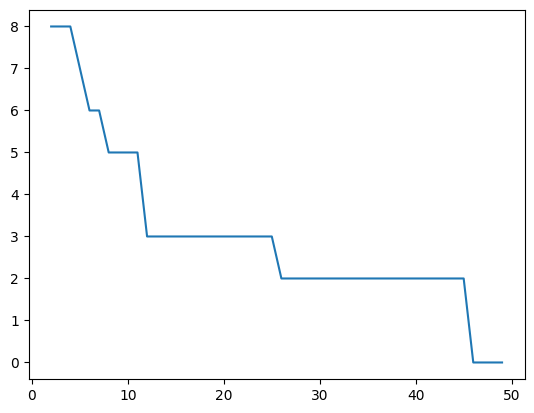

In [8]:
cluster_set = []
size_num = []
for i in range(2, 50):
    size_num.append(i)
    dbscan = hdbscan.HDBSCAN(min_samples=5, min_cluster_size =i, gen_min_span_tree=True, cluster_selection_epsilon =eps)
    cluster_lst = dbscan.fit(D)
    n_cluster = np.max(dbscan.labels_) + 1
    cluster_set.append(n_cluster)
    

plt.plot(size_num, cluster_set)

In [9]:

dbscan = hdbscan.HDBSCAN(min_samples=5, min_cluster_size = 10, gen_min_span_tree=True, cluster_selection_epsilon =eps)
cluster_lst = dbscan.fit(D)
print(f"Trajectories are grouped into {np.max(dbscan.labels_) + 1} clusters")
print(f'DBI (0 means best): {davies_bouldin_score(D, dbscan.labels_):.3f}') 
print(f'silhouette_score (1 means better): {metrics.silhouette_score(D, dbscan.labels_):.3f}') 
print(f'Calinski-Harbasz Score (Larger means better): {metrics.calinski_harabasz_score(D, dbscan.labels_):.3f}') 


Trajectories are grouped into 5 clusters
DBI (0 means best): 1.666
silhouette_score (1 means better): 0.111
Calinski-Harbasz Score (Larger means better): 5.109


In [13]:
plot_single_cluster(traj_collection_cl2sc_DP, dbscan.labels_, 4)

:Overlay
   .WMTS.I       :WMTS   [Longitude,Latitude]
   .Path.I       :Path   [Longitude,Latitude]
   .Points.I     :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.II      :WMTS   [Longitude,Latitude]
   .Path.II      :Path   [Longitude,Latitude]
   .Points.II    :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.III     :WMTS   [Longitude,Latitude]
   .Path.III     :Path   [Longitude,Latitude]
   .Points.III   :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.IV      :WMTS   [Longitude,Latitude]
   .Path.IV      :Path   [Longitude,Latitude]
   .Points.IV    :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.V       :WMTS   [Longitude,Latitude]
   .Path.V       :Path   [Longitude,Latitude]
   .Points.V     :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.VI      :WMTS   [Longitude,Latitude]
   .Path.VI      :Path   [Longitude,Latitude]
   .Points.VI    :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.VII     :WMTS   [Longitude,Latitude]
   .Path.VII     :Path   [Longitude,Latitude]
   .Points.VII   :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.VIII    :WMTS   [Longitude,Latitude]
   .Path.VIII    :Path   [Longitude,Latitude]
   .Points.VIII  :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.IX      :WMTS   [Longitude,Latitude]
   .Path.IX      :Path   [Longitude,Latitude]
   .Points.IX    :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.X       :WMTS   [Longitude,Latitude]
   .Path.X       :Path   [Longitude,Latitude]
   .Points.X     :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.XI      :WMTS   [Longitude,Latitude]
   .Path.XI      :Path   [Longitude,Latitude]
   .Points.XI    :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.XII     :WMTS   [Longitude,Latitude]
   .Path.XII     :Path   [Longitude,Latitude]
   .Points.XII   :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.XIII    :WMTS   [Longitude,Latitude]
   .Path.XIII    :Path   [Longitude,Latitude]
   .Points.XIII  :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.XIV     :WMTS   [Longitude,Latitude]
   .Path.XIV     :Path   [Longitude,Latitude]
   .Points.XIV   :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.XV      :WMTS   [Longitude,Latitude]
   .Path.XV      :Path   [Longitude,Latitude]
   .Points.XV    :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.XVI     :WMTS   [Longitude,Latitude]
   .Path.XVI     :Path   [Longitude,Latitude]
   .Points.XVI   :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.XVII    :WMTS   [Longitude,Latitude]
   .Path.XVII    :Path   [Longitude,Latitude]
   .Points.XVII  :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.XVIII   :WMTS   [Longitude,Latitude]
   .Path.XVIII   :Path   [Longitude,Latitude]
   .Points.XVIII :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.XIX     :WMTS   [Longitude,Latitude]
   .Path.XIX     :Path   [Longitude,Latitude]
   .Points.XIX   :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.XX      :WMTS   [Longitude,Latitude]
   .Path.XX      :Path   [Longitude,Latitude]
   .Points.XX    :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.XXI     :WMTS   [Longitude,Latitude]
   .Path.XXI     :Path   [Longitude,Latitude]
   .Points.XXI   :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.XXII    :WMTS   [Longitude,Latitude]
   .Path.XXII    :Path   [Longitude,Latitude]
   .Points.XXII  :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.XXIII   :WMTS   [Longitude,Latitude]
   .Path.XXIII   :Path   [Longitude,Latitude]
   .Points.XXIII :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.XXIV    :WMTS   [Longitude,Latitude]
   .Path.XXIV    :Path   [Longitude,Latitude]
   .Points.XXIV  :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.XXV     :WMTS   [Longitude,Latitude]
   .Path.XXV     :Path   [Longitude,Latitude]
   .Points.XXV   :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.XXVI   

In [10]:
label = list(dbscan.labels_)

for i in range(0, np.max(dbscan.labels_) + 1):
    print(label.count(i), 'n/')

45 n/
25 n/
11 n/
53 n/
25 n/


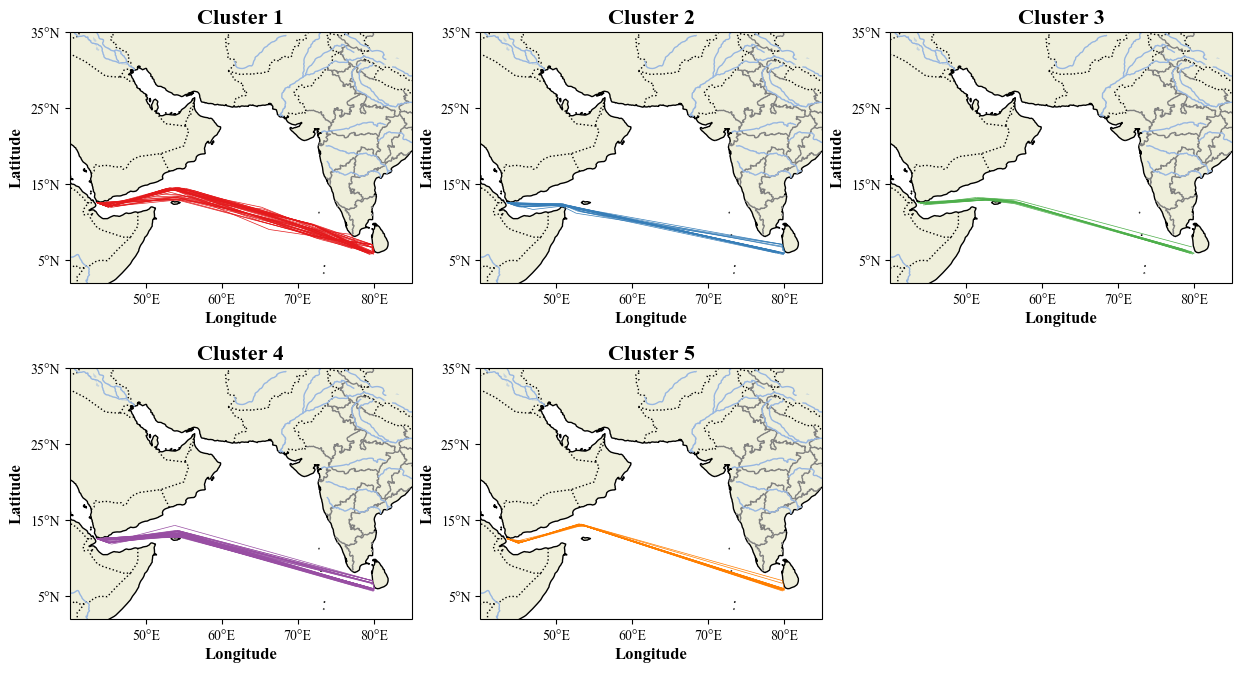

In [113]:
cluster_lst = dbscan.labels_
fig = plt.figure(figsize=(15,8))
colormp=plt.get_cmap('Set1')(range(5))
for k in range(max(dbscan.labels_)+1):
    ind = [x for x, y in list(enumerate(cluster_lst)) if y == k]
    traj_list = []
    for i in range(len(ind)):
        traj_list.append(traj_collection_cl2sc_DP.trajectories[ind[i]])
    traj_set = mpd.TrajectoryCollection(traj_list)
    ax = fig.add_subplot(2, 3, k+1, projection=ccrs.PlateCarree())
    ax = traj_set.plot(ax = ax, color=colormp[k], linewidth =  0.5)
    ax.set_extent([40, 85, 2, 30], crs=ccrs.PlateCarree())
    # ax.stock_img()
    states_provinces = cfeature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces_lines',
            scale='50m',
            facecolor='none')
    SOURCE = 'Natural Earth'
    LICENSE = 'public domain'
    # ax.add_image(imagery)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(states_provinces, edgecolor='gray')
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)

    fontlabel = {'family': 'times new roman',
            'color':  'black',
            'weight': 'bold',
            'size': 12,
            }
    fonttitle = {'family': 'times new roman',
            'color':  'black',
            'weight': 'bold',
            'size': 16,
            }

    ax.set_xticks([50, 60, 70, 80], crs=ccrs.PlateCarree())
    ax.set_yticks([5, 15, 25, 35], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    x1_label = ax.get_xticklabels() 
    [x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
    y1_label = ax.get_yticklabels() 
    [y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]
    plt.title('Cluster %d' % (k+1), fontdict=fonttitle)
    plt.xlabel('Longitude', fontdict=fontlabel)
    plt.ylabel('Latitude', fontdict=fontlabel)

#     fig.savefig('clustering_IHDBSCAN.png', dpi=600)

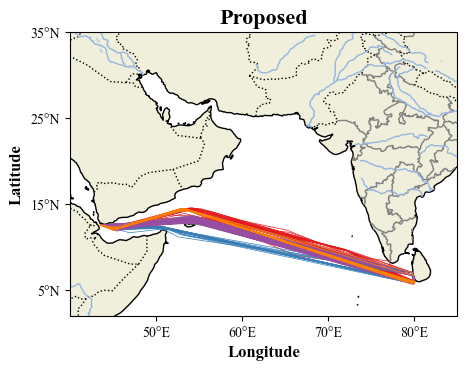

In [115]:
cluster_lst = dbscan.labels_
fig = plt.figure(figsize=(5,4))
colormp=plt.get_cmap('Set1')(range(5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
for k in range(max(dbscan.labels_)+1):
    ind = [x for x, y in list(enumerate(cluster_lst)) if y == k]
    traj_list = []
    for i in range(len(ind)):
        traj_list.append(traj_collection_cl2sc_DP.trajectories[ind[i]])
    traj_set = mpd.TrajectoryCollection(traj_list)
    ax = traj_set.plot(ax = ax, color=colormp[k], linewidth =  0.5)

ax.set_extent([40, 85, 2, 30], crs=ccrs.PlateCarree())
# ax.stock_img()
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
SOURCE = 'Natural Earth'
LICENSE = 'public domain'
# ax.add_image(imagery)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

fontlabel = {'family': 'times new roman',
        'color':  'black',
        'weight': 'bold',
        'size': 12,
        }
fonttitle = {'family': 'times new roman',
        'color':  'black',
        'weight': 'bold',
        'size': 16,
        }

ax.set_xticks([50, 60, 70, 80], crs=ccrs.PlateCarree())
ax.set_yticks([5, 15, 25, 35], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
x1_label = ax.get_xticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
y1_label = ax.get_yticklabels() 
[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]
plt.title('Proposed', fontdict=fonttitle)
plt.xlabel('Longitude', fontdict=fontlabel)
plt.ylabel('Latitude', fontdict=fontlabel)

# fig.savefig('tempfigs/set_1_IHDBSCAN.png', dpi=600)

### Lets cluster using HDBSCAN

#### Hausdoff distance

In [11]:
traj_collection_cl2sc_DP = DPcompression(traj_collection_cl2sc, 0.5)
gdf_cl2sc_DP = traj_collection_cl2sc_DP.to_traj_gdf()
traj_list = df2list(gdf_cl2sc_DP)

traj_count = len(traj_list)
D_h = np.zeros((traj_count, traj_count))
# This may take a while
for i in range(traj_count):
    for j in range(i + 1, traj_count):
        distance1 = hausdorff_distance(traj_list[i], traj_list[j], distance='haversine')
        D_h[i, j] = distance1
        D_h[j, i] = distance1

eps = find_eps(3, D_h)

Generating 230 trajectories in array form
The best eps value is 167.42933426152635


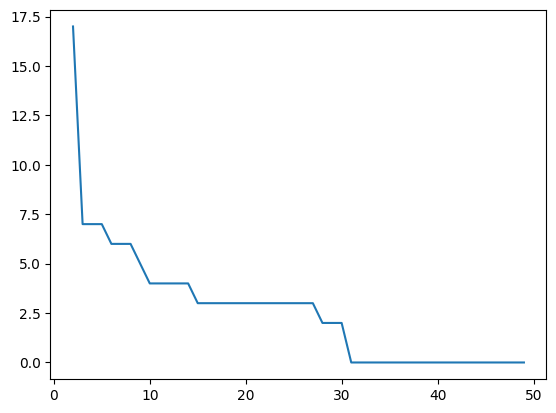

In [12]:

cluster_set = []
size_num = []
for i in range(2, 50):
    size_num.append(i)
    dbscan = hdbscan.HDBSCAN(min_samples=3, min_cluster_size =i, gen_min_span_tree=True, cluster_selection_epsilon =eps)
    cluster_lst = dbscan.fit(D_h)
    n_cluster = np.max(dbscan.labels_) + 1
    cluster_set.append(n_cluster)
    

plt.plot(size_num, cluster_set)

In [13]:
dbscan = hdbscan.HDBSCAN(min_samples=3, min_cluster_size =10,cluster_selection_epsilon =eps)
cluster_lst = dbscan.fit(D_h)
print(f"Trajectories are grouped into {np.max(dbscan.labels_) + 1} clusters")
print(f'DBI (0 means best): {davies_bouldin_score(D_h, dbscan.labels_):.3f}') 
print(f'SS (1 means better): {metrics.silhouette_score(D_h, dbscan.labels_):.3f}') 
print(f'Calinski-Harbasz Score (Larger means better): {metrics.calinski_harabasz_score(D_h, dbscan.labels_):.3f}') 



Trajectories are grouped into 4 clusters
DBI (0 means best): 1.903
SS (1 means better): 0.476
Calinski-Harbasz Score (Larger means better): 130.776


Text(0, 0.5, 'Latitude')

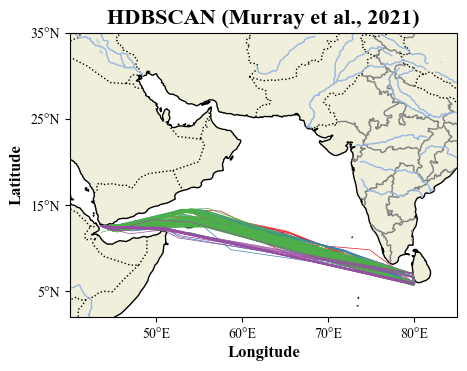

In [193]:
cluster_lst = dbscan.labels_
fig = plt.figure(figsize=(5,4))
colormp=plt.get_cmap('Set1')(range(10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
for k in range(max(dbscan.labels_)+1):
    ind = [x for x, y in list(enumerate(cluster_lst)) if y == k]
    traj_list = []
    for i in range(len(ind)):
        traj_list.append(traj_collection_cl2sc_DP.trajectories[ind[i]])
    traj_set = mpd.TrajectoryCollection(traj_list)
    ax = traj_set.plot(ax = ax, color=colormp[k], linewidth =  0.5, label= 'Cluster %d' % (k+1))

ax.set_extent([40, 85, 2, 30], crs=ccrs.PlateCarree())
# ax.stock_img()
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
SOURCE = 'Natural Earth'
LICENSE = 'public domain'
# ax.add_image(imagery)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

fontlabel = {'family': 'times new roman',
        'color':  'black',
        'weight': 'bold',
        'size': 12,
        }
fonttitle = {'family': 'times new roman',
        'color':  'black',
        'weight': 'bold',
        'size': 16,
        }

ax.set_xticks([50, 60, 70, 80], crs=ccrs.PlateCarree())
ax.set_yticks([5, 15, 25, 35], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
x1_label = ax.get_xticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
y1_label = ax.get_yticklabels() 
[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]
plt.title('HDBSCAN (Murray et al., 2021)', fontdict=fonttitle)
plt.xlabel('Longitude', fontdict=fontlabel)
plt.ylabel('Latitude', fontdict=fontlabel)
# plt.legend()

# fig.savefig('tempfigs/set_1_HDBSCAN.png', dpi=600)

In [35]:
label = list(dbscan.labels_)

for i in range(0, np.max(dbscan.labels_) + 1):
    print(label.count(i), 'n/')

24 n/
29 n/
9 n/
10 n/
11 n/
21 n/
10 n/
18 n/


### Lets cluster using DBTCAN 

In [14]:
traj_collection_cl2sc_DP = DPcompression(traj_collection_cl2sc, 0.4)
gdf_cl2sc_DP = traj_collection_cl2sc_DP.to_traj_gdf()
traj_list = df2list(gdf_cl2sc_DP)

traj_count = len(traj_list)
D_h = np.zeros((traj_count, traj_count))
# This may take a while
for i in range(traj_count):
    for j in range(i + 1, traj_count):
        distance1 = hausdorff_distance(traj_list[i], traj_list[j], distance='haversine')
        D_h[i, j] = distance1
        D_h[j, i] = distance1
eps_set = []
for i in range(2, 20):
    eps_set.append(find_eps(i, D_h))

eps_set

Generating 230 trajectories in array form
The best eps value is 114.18627746669594
The best eps value is 255.52890958282197
The best eps value is 304.33853777600956
The best eps value is 172.5963368175356
The best eps value is 209.51293656635445
The best eps value is 404.73309364012187
The best eps value is 555.3239996912287
The best eps value is 380.441071464527
The best eps value is 537.8335260510447
The best eps value is 514.3245965907334
The best eps value is 456.80338647866915
The best eps value is 598.8103768782667
The best eps value is 565.1143034241815
The best eps value is 599.6741082588514
The best eps value is 584.0822726655763
The best eps value is 600.0489403872618
The best eps value is 629.7867121618367
The best eps value is 653.2164313297161


[114.18627746669594,
 255.52890958282197,
 304.33853777600956,
 172.5963368175356,
 209.51293656635445,
 404.73309364012187,
 555.3239996912287,
 380.441071464527,
 537.8335260510447,
 514.3245965907334,
 456.80338647866915,
 598.8103768782667,
 565.1143034241815,
 599.6741082588514,
 584.0822726655763,
 600.0489403872618,
 629.7867121618367,
 653.2164313297161]

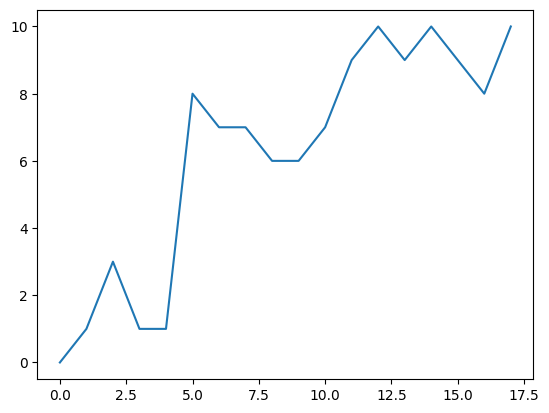

In [15]:
cluster_set = []
size_num = []
for i in range(0, len(eps_set)):
    size_num.append(i)
    mdl = DBSCAN(eps=eps_set[i], min_samples=4)
    cluster_lst = mdl.fit_predict(D_h)
    n_cluster = np.max(cluster_lst) + 1
    cluster_set.append(n_cluster)
    

plt.plot(size_num, cluster_set)

In [16]:
mdl = DBSCAN(eps=eps_set[8], min_samples=4)
cluster_lst = mdl.fit_predict(D_h)
print(f"Trajectories are grouped into {np.max(cluster_lst) + 1} clusters")
print(f'DBI (0 means best): {davies_bouldin_score(D_h, cluster_lst):.3f}') 
print(f'SS (1 means better): {metrics.silhouette_score(D_h, cluster_lst):.3f}') 
print(f'Calinski-Harbasz Score (Larger means better): {metrics.calinski_harabasz_score(D_h, cluster_lst):.3f}') 


Trajectories are grouped into 6 clusters
DBI (0 means best): 1.209
SS (1 means better): -0.138
Calinski-Harbasz Score (Larger means better): 14.936


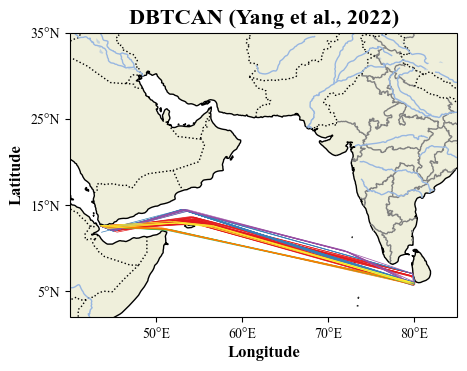

In [199]:
fig = plt.figure(figsize=(5,4))
colormp=plt.get_cmap('Set1')(range(20))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
for k in range(max(cluster_lst)+1):
    ind = [x for x, y in list(enumerate(cluster_lst)) if y == k]
    traj_list = []
    for i in range(len(ind)):
        traj_list.append(traj_collection_cl2sc_DP.trajectories[ind[i]])
    traj_set = mpd.TrajectoryCollection(traj_list)
    ax = traj_set.plot(ax = ax, color=colormp[k], linewidth =  0.5, label= 'Cluster %d' % (k+1))

ax.set_extent([40, 85, 2, 30], crs=ccrs.PlateCarree())
# ax.stock_img()
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
SOURCE = 'Natural Earth'
LICENSE = 'public domain'
# ax.add_image(imagery)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

fontlabel = {'family': 'times new roman',
        'color':  'black',
        'weight': 'bold',
        'size': 12,
        }
fonttitle = {'family': 'times new roman',
        'color':  'black',
        'weight': 'bold',
        'size': 16,
        }

ax.set_xticks([50, 60, 70, 80], crs=ccrs.PlateCarree())
ax.set_yticks([5, 15, 25, 35], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
x1_label = ax.get_xticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
y1_label = ax.get_yticklabels() 
[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]
plt.title('DBTCAN (Yang et al., 2022)', fontdict=fonttitle)
plt.xlabel('Longitude', fontdict=fontlabel)
plt.ylabel('Latitude', fontdict=fontlabel)
# plt.legend()
fig.savefig('tempfigs/set_1_DBTCAN.png', dpi=600)


### Lets cluster using DBSCAN 


In [17]:
# similarity measurements using DTW
traj_collection_cl2sc_DP = DPcompression(traj_collection_cl2sc, 0.4)
gdf_cl2sc_DP = traj_collection_cl2sc_DP.to_traj_gdf()
traj_list = df2list(gdf_cl2sc_DP)
traj_count = len(traj_list)
D = np.zeros((traj_count, traj_count))
# This may take a while
for i in range(traj_count):
    for j in range(i + 1, traj_count):
        distance1 = dtw(traj_list[i], traj_list[j], dist_method = haversine_dist, distance_only=True)
        D[i, j] = distance1.distance
        D[j, i] = distance1.distance

eps = find_eps(5, D)

Generating 230 trajectories in array form
The best eps value is 598.468404373309


In [20]:
mdl = DBSCAN(eps=eps, min_samples=5)
cluster_lst = mdl.fit_predict(D_h)
print(f"Trajectories are grouped into {np.max(cluster_lst) + 1} clusters")
print(f'DBI (0 means best): {davies_bouldin_score(D, cluster_lst):.3f}') 
print(f'SS (1 means better): {metrics.silhouette_score(D, cluster_lst):.3f}') 
print(f'Calinski-Harbasz Score (Larger means better): {metrics.calinski_harabasz_score(D, cluster_lst):.3f}') 


Trajectories are grouped into 5 clusters
DBI (0 means best): 1.557
SS (1 means better): -0.193
Calinski-Harbasz Score (Larger means better): 2.373


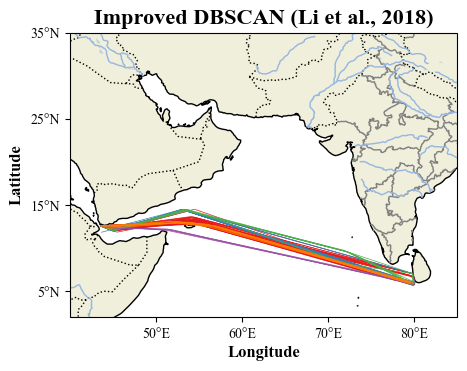

In [204]:
fig = plt.figure(figsize=(5,4))
colormp=plt.get_cmap('Set1')(range(20))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
for k in range(max(cluster_lst)+1):
    ind = [x for x, y in list(enumerate(cluster_lst)) if y == k]
    traj_list = []
    for i in range(len(ind)):
        traj_list.append(traj_collection_cl2sc_DP.trajectories[ind[i]])
    traj_set = mpd.TrajectoryCollection(traj_list)
    ax = traj_set.plot(ax = ax, color=colormp[k], linewidth =  0.5, label= 'Cluster %d' % (k+1))

ax.set_extent([40, 85, 2, 30], crs=ccrs.PlateCarree())
# ax.stock_img()
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
SOURCE = 'Natural Earth'
LICENSE = 'public domain'
# ax.add_image(imagery)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

fontlabel = {'family': 'times new roman',
        'color':  'black',
        'weight': 'bold',
        'size': 12,
        }
fonttitle = {'family': 'times new roman',
        'color':  'black',
        'weight': 'bold',
        'size': 16,
        }

ax.set_xticks([50, 60, 70, 80], crs=ccrs.PlateCarree())
ax.set_yticks([5, 15, 25, 35], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
x1_label = ax.get_xticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
y1_label = ax.get_yticklabels() 
[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]
plt.title('Improved DBSCAN (Li et al., 2018)', fontdict=fonttitle)
plt.xlabel('Longitude', fontdict=fontlabel)
plt.ylabel('Latitude', fontdict=fontlabel)
# plt.legend()
fig.savefig('tempfigs/set_1_DBSCAN.png', dpi=600)

## Lets cluster the trajectory start from Suez canal

In [14]:
traj_collection_sc2cl = mpd.TrajectoryCollection(traj_list_sc2cl)


In [15]:
# similarity measurements using DTW
traj_collection_sc2cl_DP = DPcompression(traj_collection_sc2cl, 0.4)
gdf_sc2cl_DP = traj_collection_sc2cl_DP.to_traj_gdf()
traj_list = df2list(gdf_sc2cl_DP)
traj_count = len(traj_list)
D_sc2cl = np.zeros((traj_count, traj_count))
# This may take a while
for i in range(traj_count):
    for j in range(i + 1, traj_count):
        distance1 = dtw(traj_list[i], traj_list[j], dist_method = haversine_dist, distance_only=True)
        D_sc2cl[i, j] = distance1.distance
        D_sc2cl[j, i] = distance1.distance


eps = find_eps(3, D_sc2cl)

Generating 210 trajectories in array form
The best eps value is 412.5655664353994


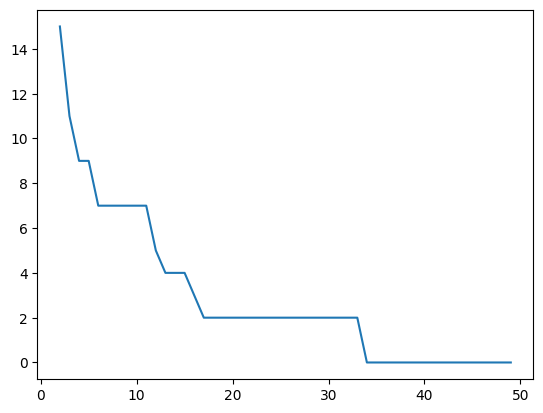

In [16]:
cluster_set = []
size_num = []
for i in range(2, 50):
    size_num.append(i)
    dbscan = hdbscan.HDBSCAN(min_samples=3, min_cluster_size =i, gen_min_span_tree=True, cluster_selection_epsilon =eps)
    cluster_lst = dbscan.fit(D_sc2cl)
    n_cluster = np.max(dbscan.labels_) + 1
    cluster_set.append(n_cluster)
    

plt.plot(size_num, cluster_set)

### Lets cluster

In [17]:
dbscan = hdbscan.HDBSCAN(min_samples=3, min_cluster_size = 12, gen_min_span_tree=True, cluster_selection_epsilon =float(eps))
cluster_lst = dbscan.fit(D_sc2cl)
print(f"Trajectories are grouped into {np.max(dbscan.labels_) + 1} clusters")
print(f'DBI (0 means best): {davies_bouldin_score(D_sc2cl, dbscan.labels_):.3f}') 
print(f'SS (1 means better): {metrics.silhouette_score(D_sc2cl, dbscan.labels_):.3f}') 
print(f'Calinski-Harbasz Score (Larger means better): {metrics.calinski_harabasz_score(D_sc2cl, dbscan.labels_):.3f}') 


Trajectories are grouped into 5 clusters
DBI (0 means best): 1.777
SS (1 means better): 0.096
Calinski-Harbasz Score (Larger means better): 16.125


In [22]:
plot_single_cluster(traj_collection_sc2cl_DP, dbscan.labels_, 4)

:Overlay
   .WMTS.I         :WMTS   [Longitude,Latitude]
   .Path.I         :Path   [Longitude,Latitude]
   .Points.I       :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.II        :WMTS   [Longitude,Latitude]
   .Path.II        :Path   [Longitude,Latitude]
   .Points.II      :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.III       :WMTS   [Longitude,Latitude]
   .Path.III       :Path   [Longitude,Latitude]
   .Points.III     :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.IV        :WMTS   [Longitude,Latitude]
   .Path.IV        :Path   [Longitude,Latitude]
   .Points.IV      :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.V         :WMTS   [Longitude,Latitude]
   .Path.V         :Path   [Longitude,Latitude]
   .Points.V       :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.VI        :WMTS   [Longitude,Latitude]
   .Path.VI        :Path   [Longitude,Latitude]
   .Points.VI      :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.VII       :WMTS   [Longitude,Latitude]
   .Path.VII       :Path   [Longitude,Latitude]
   .Points.VII     :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.VIII      :WMTS   [Longitude,Latitude]
   .Path.VIII      :Path   [Longitude,Latitude]
   .Points.VIII    :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.IX        :WMTS   [Longitude,Latitude]
   .Path.IX        :Path   [Longitude,Latitude]
   .Points.IX      :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.X         :WMTS   [Longitude,Latitude]
   .Path.X         :Path   [Longitude,Latitude]
   .Points.X       :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.XI        :WMTS   [Longitude,Latitude]
   .Path.XI        :Path   [Longitude,Latitude]
   .Points.XI      :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.XII       :WMTS   [Longitude,Latitude]
   .Path.XII       :Path   [Longitude,Latitude]
   .Points.XII     :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.XIII      :WMTS   [Longitude,Latitude]
   .Path.XIII      :Path   [Longitude,Latitude]
   .Points.XIII    :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.XIV       :WMTS   [Longitude,Latitude]
   .Path.XIV       :Path   [Longitude,Latitude]
   .Points.XIV     :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.XV        :WMTS   [Longitude,Latitude]
   .Path.XV        :Path   [Longitude,Latitude]
   .Points.XV      :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.XVI       :WMTS   [Longitude,Latitude]
   .Path.XVI       :Path   [Longitude,Latitude]
   .Points.XVI     :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.XVII      :WMTS   [Longitude,Latitude]
   .Path.XVII      :Path   [Longitude,Latitude]
   .Points.XVII    :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.XVIII     :WMTS   [Longitude,Latitude]
   .Path.XVIII     :Path   [Longitude,Latitude]
   .Points.XVIII   :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.XIX       :WMTS   [Longitude,Latitude]
   .Path.XIX       :Path   [Longitude,Latitude]
   .Points.XIX     :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.XX        :WMTS   [Longitude,Latitude]
   .Path.XX        :Path   [Longitude,Latitude]
   .Points.XX      :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.XXI       :WMTS   [Longitude,Latitude]
   .Path.XXI       :Path   [Longitude,Latitude]
   .Points.XXI     :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.XXII      :WMTS   [Longitude,Latitude]
   .Path.XXII      :Path   [Longitude,Latitude]
   .Points.XXII    :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.XXIII     :WMTS   [Longitude,Latitude]
   .Path.XXIII     :Path   [Longitude,Latitude]
   .Points.XXIII   :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.XXIV      :WMTS   [Longitude,Latitude]
   .Path.XXIV      :Path   [Longitude,Latitude]
   .Points.XXIV    :Points   [Longitude,Latitude]   (triangle_angle)
   .WMTS.XXV       :WMTS   [Lon

In [24]:
label = list(dbscan.labels_)
for i in range(0, np.max(dbscan.labels_) + 1):
    print(label.count(i))


16
15
33
28
41


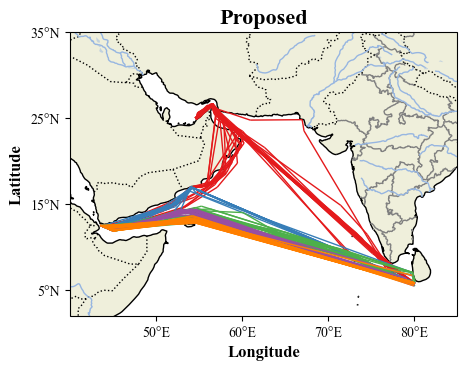

In [224]:
cluster_lst = dbscan.labels_
fig = plt.figure(figsize=(5,4))
colormp=plt.get_cmap('Set1')(range(20))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
for k in range(max(cluster_lst)+1):
    ind = [x for x, y in list(enumerate(cluster_lst)) if y == k]
    traj_list = []
    for i in range(len(ind)):
        traj_list.append(traj_collection_sc2cl_DP.trajectories[ind[i]])
    traj_set = mpd.TrajectoryCollection(traj_list)
    ax = traj_set.plot(ax = ax, color=colormp[k], linewidth =  1, label= 'Cluster %d' % (k+1))

ax.set_extent([40, 85, 2, 30], crs=ccrs.PlateCarree())
# ax.stock_img()
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
SOURCE = 'Natural Earth'
LICENSE = 'public domain'
# ax.add_image(imagery)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

fontlabel = {'family': 'times new roman',
        'color':  'black',
        'weight': 'bold',
        'size': 12,
        }
fonttitle = {'family': 'times new roman',
        'color':  'black',
        'weight': 'bold',
        'size': 16,
        }

ax.set_xticks([50, 60, 70, 80], crs=ccrs.PlateCarree())
ax.set_yticks([5, 15, 25, 35], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
x1_label = ax.get_xticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
y1_label = ax.get_yticklabels() 
[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]
plt.title('Proposed', fontdict=fonttitle)
plt.xlabel('Longitude', fontdict=fontlabel)
plt.ylabel('Latitude', fontdict=fontlabel)

# fig.savefig('tempfigs/set_1b_IHDBSCAN.png', dpi=600)

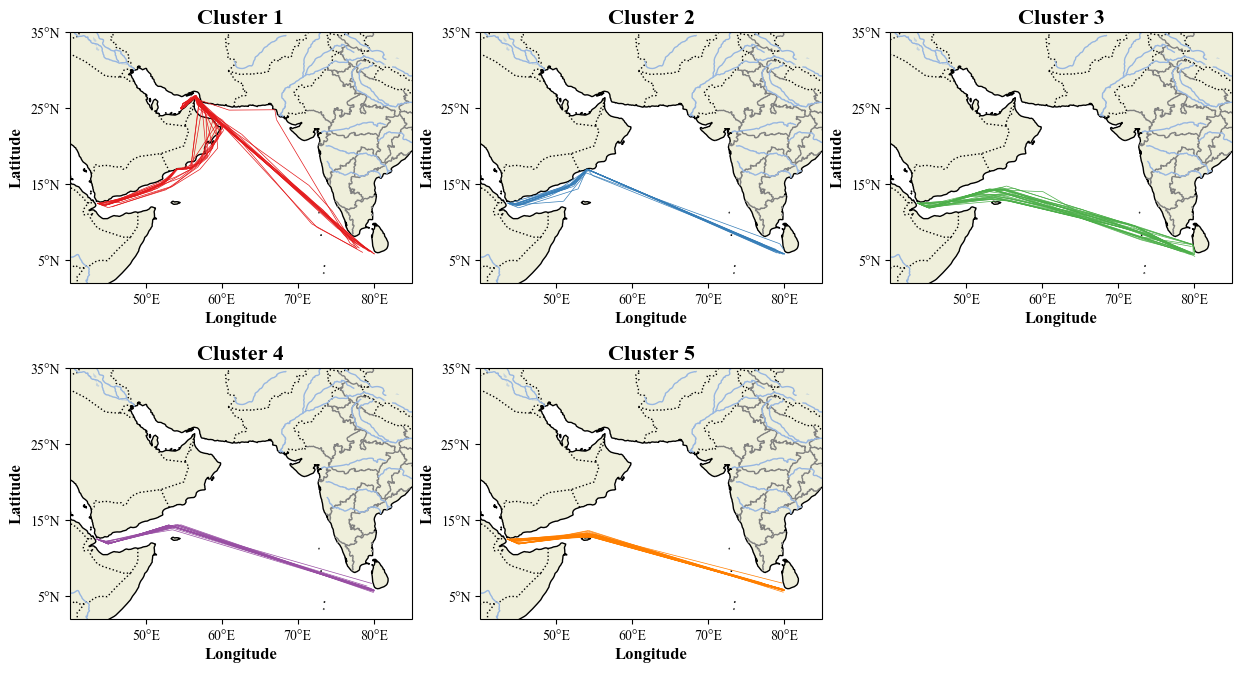

In [15]:
cluster_lst = dbscan.labels_
fig = plt.figure(figsize=(15,8))
colormp=plt.get_cmap('Set1')(range(6))
for k in range(max(dbscan.labels_)+1):
    ind = [x for x, y in list(enumerate(cluster_lst)) if y == k]
    traj_list = []
    for i in range(len(ind)):
        traj_list.append(traj_collection_sc2cl_DP.trajectories[ind[i]])
    traj_set = mpd.TrajectoryCollection(traj_list)
    ax = fig.add_subplot(2, 3, k+1, projection=ccrs.PlateCarree())
    ax = traj_set.plot(ax = ax, color=colormp[k], linewidth =  0.5)
    ax.set_extent([40, 85, 2, 30], crs=ccrs.PlateCarree())
    # ax.stock_img()
    states_provinces = cfeature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces_lines',
            scale='50m',
            facecolor='none')
    SOURCE = 'Natural Earth'
    LICENSE = 'public domain'
    # ax.add_image(imagery)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(states_provinces, edgecolor='gray')
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)

    fontlabel = {'family': 'times new roman',
            'color':  'black',
            'weight': 'bold',
            'size': 12,
            }
    fonttitle = {'family': 'times new roman',
            'color':  'black',
            'weight': 'bold',
            'size': 16,
            }

    ax.set_xticks([50, 60, 70, 80], crs=ccrs.PlateCarree())
    ax.set_yticks([5, 15, 25, 35], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    x1_label = ax.get_xticklabels() 
    [x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
    y1_label = ax.get_yticklabels() 
    [y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]
    plt.title('Cluster %d' % (k+1), fontdict=fonttitle)
    plt.xlabel('Longitude', fontdict=fontlabel)
    plt.ylabel('Latitude', fontdict=fontlabel)

    fig.savefig('tempfigs/set_1b_IHDBSCAN_cluster.png', dpi=600)


### HDBSCAN

In [25]:
traj_collection_sc2cl_DP = DPcompression(traj_collection_sc2cl, 0.4)
gdf_sc2cl_DP = traj_collection_sc2cl_DP.to_traj_gdf()
traj_list = df2list(gdf_sc2cl_DP)

traj_count = len(traj_list)
D_h = np.zeros((traj_count, traj_count))
# This may take a while
for i in range(traj_count):
    for j in range(i + 1, traj_count):
        distance1 = hausdorff_distance(traj_list[i], traj_list[j], distance='haversine')
        D_h[i, j] = distance1
        D_h[j, i] = distance1

eps = find_eps(3, D_h)

Generating 210 trajectories in array form
The best eps value is 233.60841319304166


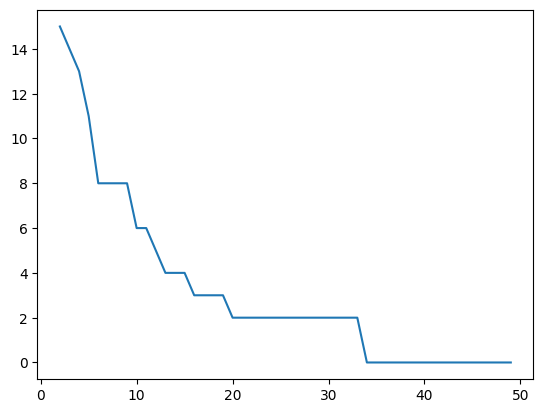

In [26]:
cluster_set = []
size_num = []
for i in range(2, 50):
    size_num.append(i)
    dbscan = hdbscan.HDBSCAN(min_samples=3, min_cluster_size =i, gen_min_span_tree=True, cluster_selection_epsilon =eps)
    cluster_lst = dbscan.fit(D_h)
    n_cluster = np.max(dbscan.labels_) + 1
    cluster_set.append(n_cluster)
    

plt.plot(size_num, cluster_set)

In [27]:
dbscan = hdbscan.HDBSCAN(min_samples=3, min_cluster_size =25,cluster_selection_epsilon =eps)
cluster_lst = dbscan.fit(D_h)
print(f"Trajectories are grouped into {np.max(dbscan.labels_) + 1} clusters")
print(f'DBI (0 means best): {davies_bouldin_score(D_h, dbscan.labels_):.3f}') 
print(f'SS (1 means better): {metrics.silhouette_score(D_h, dbscan.labels_):.3f}') 
print(f'Calinski-Harbasz Score (Larger means better): {metrics.calinski_harabasz_score(D_h, dbscan.labels_):.3f}') 



Trajectories are grouped into 2 clusters
DBI (0 means best): 0.602
SS (1 means better): 0.603
Calinski-Harbasz Score (Larger means better): 423.818


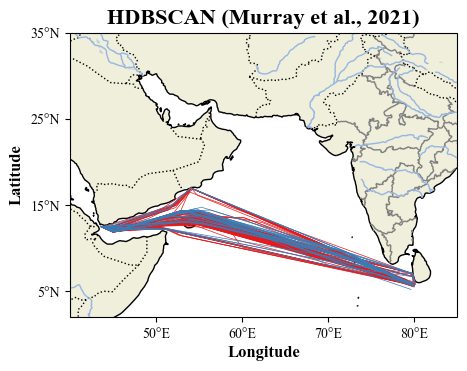

In [242]:
cluster_lst = dbscan.labels_
fig = plt.figure(figsize=(5,4))
colormp=plt.get_cmap('Set1')(range(20))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
for k in range(max(cluster_lst)+1):
    ind = [x for x, y in list(enumerate(cluster_lst)) if y == k]
    traj_list = []
    for i in range(len(ind)):
        traj_list.append(traj_collection_sc2cl_DP.trajectories[ind[i]])
    traj_set = mpd.TrajectoryCollection(traj_list)
    ax = traj_set.plot(ax = ax, color=colormp[k], linewidth =  0.5, label= 'Cluster %d' % (k+1))

ax.set_extent([40, 85, 2, 30], crs=ccrs.PlateCarree())
# ax.stock_img()
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
SOURCE = 'Natural Earth'
LICENSE = 'public domain'
# ax.add_image(imagery)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

fontlabel = {'family': 'times new roman',
        'color':  'black',
        'weight': 'bold',
        'size': 12,
        }
fonttitle = {'family': 'times new roman',
        'color':  'black',
        'weight': 'bold',
        'size': 16,
        }

ax.set_xticks([50, 60, 70, 80], crs=ccrs.PlateCarree())
ax.set_yticks([5, 15, 25, 35], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
x1_label = ax.get_xticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
y1_label = ax.get_yticklabels() 
[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]
plt.title('HDBSCAN (Murray et al., 2021)', fontdict=fonttitle)
plt.xlabel('Longitude', fontdict=fontlabel)
plt.ylabel('Latitude', fontdict=fontlabel)
# fig.savefig('tempfigs/set_1b_HDBSCAN.png', dpi=600)

### DBTCAN

In [28]:
traj_collection_sc2cl_DP = DPcompression(traj_collection_sc2cl, 0.4)
gdf_sc2cl_DP = traj_collection_sc2cl_DP.to_traj_gdf()
traj_list = df2list(gdf_sc2cl_DP)

traj_count = len(traj_list)
D_h = np.zeros((traj_count, traj_count))
# This may take a while
for i in range(traj_count):
    for j in range(i + 1, traj_count):
        distance1 = hausdorff_distance(traj_list[i], traj_list[j], distance='haversine')
        D_h[i, j] = distance1
        D_h[j, i] = distance1

for i in range(2, 20):
    eps_set.append(find_eps(i, D_h))

eps_set

Generating 210 trajectories in array form
The best eps value is 119.47306088074566
The best eps value is 233.60841319304166
The best eps value is 255.8170090795395
The best eps value is 301.5414332139418
The best eps value is 297.24078520191574
The best eps value is 333.9467296058242
The best eps value is 438.18182745412395
The best eps value is 394.93117322408546
The best eps value is 446.4397288264242
The best eps value is 446.4397288264242
The best eps value is 364.27989676604926
The best eps value is 434.5144306781368
The best eps value is 434.77890945926123
The best eps value is 452.31450626226297
The best eps value is 544.0875078894157
The best eps value is 575.8349721270672
The best eps value is 526.5935820765797
The best eps value is 546.6333087909812


[114.18627746669594,
 255.52890958282197,
 304.33853777600956,
 172.5963368175356,
 209.51293656635445,
 404.73309364012187,
 555.3239996912287,
 380.441071464527,
 537.8335260510447,
 514.3245965907334,
 456.80338647866915,
 598.8103768782667,
 565.1143034241815,
 599.6741082588514,
 584.0822726655763,
 600.0489403872618,
 629.7867121618367,
 653.2164313297161,
 119.47306088074566,
 233.60841319304166,
 255.8170090795395,
 301.5414332139418,
 297.24078520191574,
 333.9467296058242,
 438.18182745412395,
 394.93117322408546,
 446.4397288264242,
 446.4397288264242,
 364.27989676604926,
 434.5144306781368,
 434.77890945926123,
 452.31450626226297,
 544.0875078894157,
 575.8349721270672,
 526.5935820765797,
 546.6333087909812]

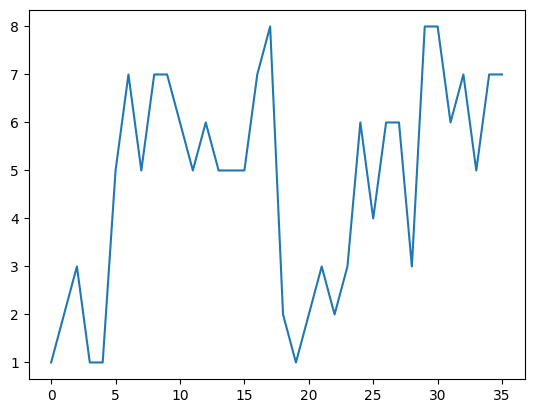

In [29]:
cluster_set = []
size_num = []
for i in range(0, len(eps_set)):
    size_num.append(i)
    mdl = DBSCAN(eps=eps_set[i], min_samples=4)
    cluster_lst = mdl.fit_predict(D_h)
    n_cluster = np.max(cluster_lst) + 1
    cluster_set.append(n_cluster)
    

plt.plot(size_num, cluster_set)

In [31]:
mdl = DBSCAN(eps=eps_set[15], min_samples=4)
cluster_lst = mdl.fit_predict(D_h)
print(f"Trajectories are grouped into {np.max(cluster_lst) + 1} clusters")
print(f'DBI (0 means best): {davies_bouldin_score(D_h, cluster_lst):.3f}') 
print(f'SS (1 means better): {metrics.silhouette_score(D_h, cluster_lst):.3f}') 
print(f'Calinski-Harbasz Score (Larger means better): {metrics.calinski_harabasz_score(D_h, cluster_lst):.3f}') 


Trajectories are grouped into 5 clusters
DBI (0 means best): 1.086
SS (1 means better): -0.029
Calinski-Harbasz Score (Larger means better): 21.248


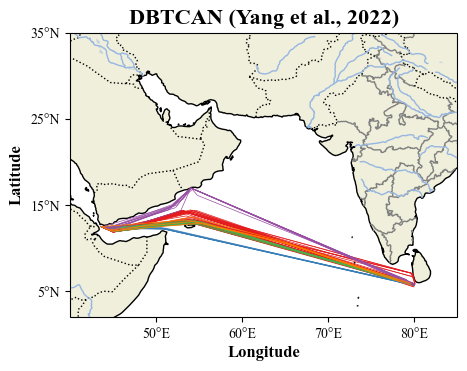

In [247]:
fig = plt.figure(figsize=(5,4))
colormp=plt.get_cmap('Set1')(range(20))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
for k in range(max(cluster_lst)+1):
    ind = [x for x, y in list(enumerate(cluster_lst)) if y == k]
    traj_list = []
    for i in range(len(ind)):
        traj_list.append(traj_collection_sc2cl_DP.trajectories[ind[i]])
    traj_set = mpd.TrajectoryCollection(traj_list)
    ax = traj_set.plot(ax = ax, color=colormp[k], linewidth =  0.5, label= 'Cluster %d' % (k+1))

ax.set_extent([40, 85, 2, 30], crs=ccrs.PlateCarree())
# ax.stock_img()
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
SOURCE = 'Natural Earth'
LICENSE = 'public domain'
# ax.add_image(imagery)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

fontlabel = {'family': 'times new roman',
        'color':  'black',
        'weight': 'bold',
        'size': 12,
        }
fonttitle = {'family': 'times new roman',
        'color':  'black',
        'weight': 'bold',
        'size': 16,
        }

ax.set_xticks([50, 60, 70, 80], crs=ccrs.PlateCarree())
ax.set_yticks([5, 15, 25, 35], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
x1_label = ax.get_xticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
y1_label = ax.get_yticklabels() 
[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]
plt.title('DBTCAN (Yang et al., 2022)', fontdict=fonttitle)
plt.xlabel('Longitude', fontdict=fontlabel)
plt.ylabel('Latitude', fontdict=fontlabel)
fig.savefig('tempfigs/set_1b_DBTCAN.png', dpi=600)

### Improved DBSCAN

In [32]:
# similarity measurements using DTW
traj_collection_sc2cl_DP = DPcompression(traj_collection_sc2cl, 0.4)
gdf_sc2cl_DP = traj_collection_sc2cl_DP.to_traj_gdf()
traj_list = df2list(gdf_sc2cl_DP)

traj_count = len(traj_list)
D = np.zeros((traj_count, traj_count))
# This may take a while
for i in range(traj_count):
    for j in range(i + 1, traj_count):
        distance1 = dtw(traj_list[i], traj_list[j], dist_method = haversine_dist, distance_only=True)
        D[i, j] = distance1.distance
        D[j, i] = distance1.distance

eps = find_eps(2, D)

Generating 210 trajectories in array form
The best eps value is 284.9663556970225


In [33]:
mdl = DBSCAN(eps=eps, min_samples=3)
cluster_lst = mdl.fit_predict(D_h)
print(f"Trajectories are grouped into {np.max(cluster_lst) + 1} clusters")
print(f'DBI (0 means best): {davies_bouldin_score(D, cluster_lst):.3f}') 
print(f'SS (1 means better): {metrics.silhouette_score(D, cluster_lst):.3f}') 
print(f'Calinski-Harbasz Score (Larger means better): {metrics.calinski_harabasz_score(D, cluster_lst):.3f}') 


Trajectories are grouped into 3 clusters
DBI (0 means best): 1.522
SS (1 means better): -0.425
Calinski-Harbasz Score (Larger means better): 1.168


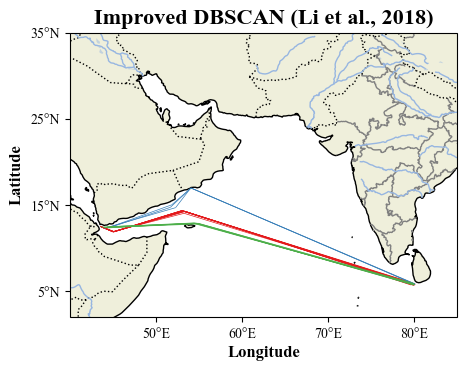

In [267]:
fig = plt.figure(figsize=(5,4))
colormp=plt.get_cmap('Set1')(range(20))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
for k in range(max(cluster_lst)+1):
    ind = [x for x, y in list(enumerate(cluster_lst)) if y == k]
    traj_list = []
    for i in range(len(ind)):
        traj_list.append(traj_collection_sc2cl_DP.trajectories[ind[i]])
    traj_set = mpd.TrajectoryCollection(traj_list)
    ax = traj_set.plot(ax = ax, color=colormp[k], linewidth =  0.5, label= 'Cluster %d' % (k+1))

ax.set_extent([40, 85, 2, 30], crs=ccrs.PlateCarree())
# ax.stock_img()
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
SOURCE = 'Natural Earth'
LICENSE = 'public domain'
# ax.add_image(imagery)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

fontlabel = {'family': 'times new roman',
        'color':  'black',
        'weight': 'bold',
        'size': 12,
        }
fonttitle = {'family': 'times new roman',
        'color':  'black',
        'weight': 'bold',
        'size': 16,
        }

ax.set_xticks([50, 60, 70, 80], crs=ccrs.PlateCarree())
ax.set_yticks([5, 15, 25, 35], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
x1_label = ax.get_xticklabels() 
[x1_label_temp.set_fontname('Times New Roman') for x1_label_temp in x1_label]
y1_label = ax.get_yticklabels() 
[y1_label_temp.set_fontname('Times New Roman') for y1_label_temp in y1_label]
plt.title('Improved DBSCAN (Li et al., 2018)', fontdict=fonttitle)
plt.xlabel('Longitude', fontdict=fontlabel)
plt.ylabel('Latitude', fontdict=fontlabel)

fig.savefig('tempfigs/set_1b_DBSCAN.png', dpi=600)

In [4]:
from OD_cluster import *
from utils import *
traj_ST = STcompression(traj, 0.6)

In [5]:
aggregator = OD_cluster(traj_ST, max_distance=25, min_distance=3,min_stop_duration=timedelta(hours=12))
points = aggregator.significant_points
flows = aggregator.get_flows_gdf()
clusters = aggregator.return_clusters_gdf()

Extracting significant points ...


In [23]:
clusters

geometry    n
0    POINT (79.33112 6.24828)  543
1   POINT (43.94005 12.39918)  457
2   POINT (53.86711 13.89126)  158
3   POINT (50.90402 12.30747)   27
4   POINT (56.47244 26.58367)   19
5   POINT (70.98744 18.97022)    5
6   POINT (68.83220 22.24882)   16
7   POINT (54.03385 16.64922)   22
8    POINT (73.19782 7.94255)    6
9    POINT (71.97347 9.18278)   10
10  POINT (60.05572 22.08667)    5

In [83]:
flows

geometry  weight
0    LINESTRING (79.33112 6.24828, 50.90402 12.30747)      21
1   LINESTRING (50.90402 12.30747, 43.94005 12.39918)      41
2    LINESTRING (79.33112 6.24828, 53.86711 13.89126)     147
3   LINESTRING (53.86711 13.89126, 43.94005 12.39918)     195
4     LINESTRING (79.33112 6.24828, 71.97347 9.18278)      51
..                                                ...     ...
60  LINESTRING (56.47244 26.58367, 60.05572 22.08667)       2
61  LINESTRING (60.05572 22.08667, 70.98744 18.97022)       1
62   LINESTRING (79.33112 6.24828, 60.05572 22.08667)       1
63  LINESTRING (60.05572 22.08667, 68.83220 22.24882)       1
64   LINESTRING (68.83220 22.24882, 79.33112 6.24828)       1

[65 rows x 2 columns]

In [10]:
points = clusters.geometry
xs = [point.x for point in points]
ys = [point.y for point in points]
CPs = pd.DataFrame(xs, ys)
CPs.to_csv('Node_set_1.csv')



In [44]:
# newcluster = clusters.iloc[[0, 1, 5, 6, 8, 9], :]
# newcluster.reset_index(drop=True)

# points = newcluster.geometry
# # df = pd.DataFrame(xs, ys)
# # X = np.array([(point.x, point.y) for point in points])
# # df.to_csv('extracted.csv')
# xs = [point.x for point in points]
# ys = [point.y for point in points]
# df = pd.DataFrame(xs, ys)
# df.to_csv('local_node_set_1.csv')
# newcluster.to_csv('local_node_set_1.csv')

In [6]:
fonttitle = {'family': 'times new roman',
        'color':  'black',
        'weight': 'bold',
        'size': 18,
        }
flows.hvplot(title='Traffic flows', fontsize = 16, geo=True, hover_cols=['lime'], line_width=10, alpha=0.4, color='lime', tiles='ESRI', frame_height=800, frame_width=500) * clusters.hvplot(geo=True, c = 'n', size=280, tiles='ESRI', cmap='autumn') 

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Path.I   :Path   [Longitude,Latitude]
   .WMTS.II  :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (n)